In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys

sys.path.append("../incl/")

import ELPH_dyn
import narrom

In [2]:
trajectories = narrom.utils.load_trajectories(filename='/home/agluedge/Preprints/ELPH/runs/runs_n_kmax=200.npz')


for k in range(len(trajectories)):
    trajectories[k] = trajectories[k].T

n_trajectories = len(trajectories)
n_kmax = trajectories[0].shape[1]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)

test_trajectory = narrom.utils.load_trajectories(filename='/home/agluedge/Preprints/ELPH/example_run.npz')[0].T
print('example trajectory loaded with shape: ', test_trajectory.shape)


1000 loaded with n_kmax = 200
example trajectory loaded with shape:  (400, 200)


In [3]:
optimizer = narrom.optimizer.ridge(alpha=10.**-3.5)
scaler = narrom.scaler.normalize_scaler(0.1)
dim_reducer = narrom.dim_reducer.SVD()
transformer = narrom.transformer.polynomial_features(order=2)

model = narrom.narrom(trajectories, VAR_l=2, intercept=True, full_hist=False, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=transformer)
model.train(rdim=20, prdim = 20)
model.print_status()

full_hist:  False
intercept:  True
standardize:  True
rdim:  20
prdim:  20
VAR_l:  2
train shape:  (399000, 861)
target shape:  (399000, 20)
weights shape:  (861, 20)


In [4]:
pred = model.predict_test_trajectory(test_trajectory)

print('std error: ', model.get_error(test_trajectory, pred, norm='NF') )
print('max error: ', model.get_error(test_trajectory, pred, norm='max') )

std error:  0.003235832455843973
max error:  0.09517082553297851


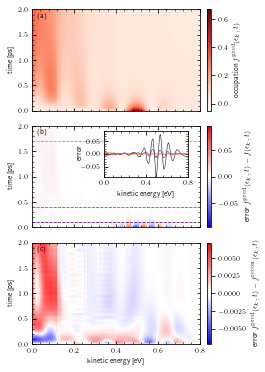

In [6]:
import matplotlib.colors as colors

tmax = 2
n_tmax = 400
kmax = 4

cmap = plt.get_cmap('inferno')


E_el = ELPH_dyn.electron_dispersion(np.linspace(0,kmax,n_kmax,endpoint=True),0)
t = np.linspace(0,tmax,test_trajectory.shape[0])

err = pred-test_trajectory

test_trajectory_SVDapprx = dim_reducer.reconstruct( dim_reducer.reduce(test_trajectory,20) )
err_SVD = pred - test_trajectory_SVDapprx

####################################################
####################################################
####################################################

from matplotlib import rc
rc('text', usetex=True)

from matplotlib import gridspec
import matplotlib.ticker as ticker

fs = 7
fig = plt.figure(figsize=(3.5,5.0))
plt.rcParams.update({'font.size': fs})
gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[1,0.025], height_ratios=[1,1,1])


####################################################
####################################################
####################################################


ax00 = plt.subplot(gs[0,0])

im = plt.pcolormesh(E_el,t,pred, cmap='Reds', shading='auto', rasterized=True)
# cbar = plt.colorbar()
# cbar.set_label(r'error')

# plt.ylim(0,1.2)
plt.xlim(0,0.8)


plt.ylabel(r'time [ps]')
# plt.xlabel(r'kinetic energy [eV]')

ax00.xaxis.set_ticks_position('both')
ax00.yaxis.set_ticks_position('both')
ax00.tick_params(which='both', direction='in', color='k')

ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax00.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax00.xaxis.set_major_formatter(ticker.NullFormatter())
ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

ax00.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax00.xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
#ax00.yaxis.set_major_formatter(ticker.NullFormatter())
#ax00.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.text(0.03, 0.97,r'(a)', horizontalalignment='left', verticalalignment='top', transform=ax00.transAxes)


axCB = plt.subplot(gs[0,1])

cb = plt.colorbar(im, cax = axCB)
cb.set_label(r"occupation $f^{\rm pred}(\epsilon_k, t)$")


####################################################
####################################################
####################################################


tn_arr = np.array([0,0.1,0.4,1.7])*400/2.0
tn_arr = tn_arr.astype(int)


ax00 = plt.subplot(gs[1,0])


im = plt.pcolormesh(E_el,t,err,norm=colors.CenteredNorm(vcenter=0.0), cmap='bwr', shading='auto', rasterized=True)
# cbar = plt.colorbar()
# cbar.set_label(r'error')


for k,tn in enumerate(tn_arr):
    plt.axhline(y=t[tn], xmin=0, xmax=1, ls='--', color=cmap(k/len(tn_arr)),  lw = 0.8)


# plt.ylim(0,1.2)
plt.xlim(0,0.8)


plt.ylabel(r'time [ps]')
# plt.xlabel(r'kinetic energy [eV]')

ax00.xaxis.set_ticks_position('both')
ax00.yaxis.set_ticks_position('both')
ax00.tick_params(which='both', direction='in', color='k')

ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax00.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax00.xaxis.set_major_formatter(ticker.NullFormatter())
ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

ax00.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax00.xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
#ax00.yaxis.set_major_formatter(ticker.NullFormatter())
#ax00.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.text(0.03, 0.97,r'(b)', horizontalalignment='left', verticalalignment='top', transform=ax00.transAxes)


axCB = plt.subplot(gs[1,1])

cb = plt.colorbar(im, cax = axCB)
cb.set_label(r"error $f^{\rm pred}(\epsilon_k, t) - f(\epsilon_k, t)$")


####################################################
####################################################
####################################################


axins = ax00.inset_axes([0.43, 0.5, 0.50, 0.45])

cmap = plt.get_cmap('inferno')
# tn_arr = np.geomspace(1,n_tmax,5,dtype=int)-1

# axins.grid(0.5)
for k,tn in enumerate(tn_arr):
    axins.plot(E_el,err[tn], '-', c=cmap(k/len(tn_arr)), lw = 0.5)
    
    
axins.plot([-2,-1],[1,1],'-', label='prediction', c='k', lw=0.7)
axins.plot([-2,-1],[1,1],'--', label='truth', c='k', lw=0.7)
# plt.legend(fontsize=fs-1)
    
axins.set_xlabel('kinetic energy [eV]')
axins.set_ylabel('error',labelpad=-2)
axins.set_xlim(0,0.8)
axins.set_ylim(-0.09,0.09)


axins.xaxis.set_ticks_position('both')
axins.yaxis.set_ticks_position('both')
axins.tick_params(which='both', direction='in', color='k')

axins.xaxis.set_major_locator(ticker.MultipleLocator(0.4))
axins.xaxis.set_minor_locator(ticker.MultipleLocator(0.08))
# ax00.xaxis.set_major_formatter(ticker.NullFormatter())
# ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

axins.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
axins.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
#ax00.yaxis.set_major_formatter(ticker.NullFormatter())
#ax00.yaxis.set_minor_formatter(ticker.NullFormatter())



####################################################
####################################################
####################################################

####################################################
####################################################
####################################################


ax00 = plt.subplot(gs[2,0])


im = plt.pcolormesh(E_el,t,err_SVD,norm=colors.CenteredNorm(0.0), cmap='bwr', shading='auto', rasterized=True)
# cbar = plt.colorbar()
# cbar.set_label(r'error')

# plt.ylim(0,1.2)
plt.xlim(0,0.8)


plt.ylabel(r'time [ps]')
plt.xlabel(r'kinetic energy [eV]')

ax00.xaxis.set_ticks_position('both')
ax00.yaxis.set_ticks_position('both')
ax00.tick_params(which='both', direction='in', color='k')

ax00.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax00.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
# ax00.xaxis.set_major_formatter(ticker.NullFormatter())
# ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

ax00.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax00.xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
#ax00.yaxis.set_major_formatter(ticker.NullFormatter())
#ax00.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.text(0.03, 0.97,r'(c)', horizontalalignment='left', verticalalignment='top', transform=ax00.transAxes)


axCB = plt.subplot(gs[2,1])

cb = plt.colorbar(im, cax = axCB)
cb.set_label(r"error $f^{\rm pred}(\epsilon_k, t) - f^{\rm recon}(\epsilon_k, t)$")


####################################################
####################################################
####################################################


# axins = ax00.inset_axes([0.43, 0.5, 0.50, 0.45])

# cmap = plt.get_cmap('inferno')
# tn_arr = np.geomspace(1,n_tmax,5,dtype=int)-1

# # axins.grid(0.5)
# for k,tn in enumerate(tn_arr):
#     axins.plot(E_el,err_SVD[:,tn], '-', c=cmap(k/len(tn_arr)), lw = 0.5)
    
    
# axins.plot([-2,-1],[1,1],'-', label='prediction', c='k', lw=0.7)
# axins.plot([-2,-1],[1,1],'--', label='truth', c='k', lw=0.7)
# # plt.legend(fontsize=fs-1)
    
# axins.set_xlabel('kinetic energy [eV]')
# axins.set_ylabel('error',labelpad=-2)
# axins.set_xlim(0,0.8)
# axins.set_ylim(-0.005,0.007)


# axins.xaxis.set_ticks_position('both')
# axins.yaxis.set_ticks_position('both')
# axins.tick_params(which='both', direction='in', color='k')

# axins.xaxis.set_major_locator(ticker.MultipleLocator(0.4))
# axins.xaxis.set_minor_locator(ticker.MultipleLocator(0.08))
# # ax00.xaxis.set_major_formatter(ticker.NullFormatter())
# # ax00.xaxis.set_minor_formatter(ticker.NullFormatter())

# axins.yaxis.set_major_locator(ticker.MultipleLocator(0.005))
# axins.yaxis.set_minor_locator(ticker.MultipleLocator(0.001))
# #ax00.yaxis.set_major_formatter(ticker.NullFormatter())
# #ax00.yaxis.set_minor_formatter(ticker.NullFormatter())



####################################################
####################################################
####################################################



plt.tight_layout()

plt.subplots_adjust(left=0.11, bottom=0.06, right=0.82, top=0.99, wspace=0.08, hspace=0.15)

plt.savefig('/home/agluedge/Preprints/ELPH/figs/autoregression_example.pdf', dpi=600)
plt.show()

